<a href="https://colab.research.google.com/github/ggwnsghgg/Exchange_rate_prediction_Project/blob/main/LSTM_%EC%98%88%EC%8B%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
filename = '/content/drive/My Drive/Test_data.csv'

In [93]:
data = pd.read_csv(filename)
data.head()

,Date,ExchangeRate,Swap Rate -1Y,KORIBOR,LIBOR,달러지수 (종가),콜금리,KOSPI
0,2014.01.02,1.06,0.0956,2.78,0.0956,80.79,2.51,1.967.19
1,2014.01.03,1.05,0.0950,2.78,0.0950,80.96,2.50,1.946.14
2,2014.01.06,1.05,0.0945,2.77,0.0945,80.81,2.48,1.953.28
3,2014.01.07,1.06,0.0926,2.75,0.0926,80.98,2.50,1.959.44
4,2014.01.08,1.07,0.0925,2.75,0.0925,81.16,2.49,1.958.96


In [94]:
data.isnull().sum()

Date              0
ExchangeRate      0
Swap Rate -1Y    88
KORIBOR           0
LIBOR            92
달러지수 (종가)         7
콜금리               0
KOSPI             7
dtype: int64

In [95]:
data.interpolate(inplace=True)
data.isnull().sum()

Date             0
ExchangeRate     0
Swap Rate -1Y    0
KORIBOR          0
LIBOR            0
달러지수 (종가)        0
콜금리              0
KOSPI            7
dtype: int64

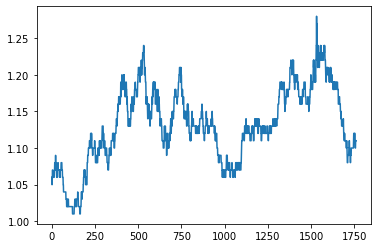

In [96]:
plt.plot(data['ExchangeRate'])

In [97]:
 df = data['ExchangeRate']
 print(df)

0       1.06
1       1.05
2       1.05
3       1.06
4       1.07
        ... 
1757    1.10
1758    1.11
1759    1.11
1760    1.11
1761    1.11
Name: ExchangeRate, Length: 1762, dtype: float64


In [134]:
# create windows
# 최근 50일간의 데이터를 확인하여 내일을 예측
seq_len = 360
sequence_length = seq_len + 1

result = []
for index in range(len(df) - sequence_length):
    result.append(df[index: index + sequence_length])

In [135]:
# z-score 정규화
normalized_data = []
window_mean = []
window_std = []

for window in result:
    normalized_window = [((p - np.mean(window)) / np.std(window)) for p in window]
    normalized_data.append(normalized_window)
    window_mean.append(np.mean(window))
    window_std.append(np.std(window))

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
# shuffle을 해도, 51개의 묶음은 변하지 않으므로 상관없음
# 50일(x)로 1일(y) 예측
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1261, 360, 1), (140, 360, 1))

In [136]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(32, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 21,057
Trainable params: 21,057
Non-trainable params: 0
_________________________________________________________________


In [137]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=10)

Epoch 1/10
127/127 [==============================] - 34s 247ms/step - loss: 0.4270 - val_loss: 0.1892
Epoch 2/10
127/127 [==============================] - 33s 256ms/step - loss: 0.1196 - val_loss: 0.1150
Epoch 3/10
127/127 [==============================] - 33s 262ms/step - loss: 0.0805 - val_loss: 0.0780
Epoch 4/10
127/127 [==============================] - 33s 263ms/step - loss: 0.0684 - val_loss: 0.1315
Epoch 5/10
127/127 [==============================] - 34s 271ms/step - loss: 0.0637 - val_loss: 0.0918
Epoch 6/10
127/127 [==============================] - 35s 274ms/step - loss: 0.0543 - val_loss: 0.0569
Epoch 7/10
127/127 [==============================] - 34s 271ms/step - loss: 0.0533 - val_loss: 0.0559
Epoch 8/10
127/127 [==============================] - 33s 258ms/step - loss: 0.0525 - val_loss: 0.0890
Epoch 9/10
127/127 [==============================] - 33s 264ms/step - loss: 0.0545 - val_loss: 0.0583
Epoch 10/10
127/127 [==============================] - 35s 273ms/step - l

In [138]:
pred = model.predict(x_test)

In [139]:
# 복원
pred_result = []
pred_y = []
for i in range(len(pred)):
    n1 = (pred[i] * window_std[i]) + window_mean[i]
    n2 = (y_test[i] * window_std[i]) + window_mean[i]
    pred_result.append(n1)
    pred_y.append(n2)

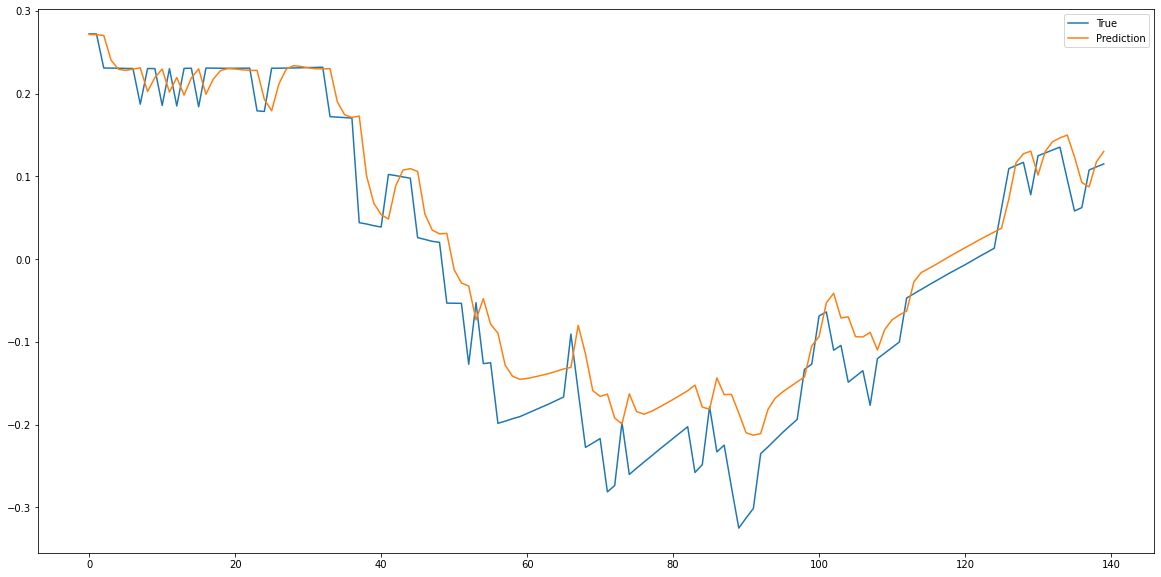

In [140]:

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(pred_y, label='True')
ax.plot(pred_result, label='Prediction')
ax.legend()
plt.show()